# Imports e Funções

In [32]:
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

In [33]:
def analise_df (df):
    print(df.info())
    print(df.describe())


def display_all(df):
    with pd.option_context("display.max_rows", 50):
        with pd.option_context("display.max_columns", 10):
            display(df)

def format_data(df):
    df['data'] = pd.to_datetime(df['data'])
    df.set_index('data', inplace=True)
    df = df.sort_index()
    return df

def plot_not_nan (df, col):
  df.dropna(subset=[col], inplace=True)
  df[col].plot()
  plt.show()


# Definição dos caminhos e organização inicial de arquivos

In [34]:
local_path = os.getcwd()
data_path = os.path.join(local_path, 'data')
file_name = 'dataset.csv'
source_path = os.path.join(local_path, file_name)
file_path = os.path.join(data_path, file_name)


if not os.path.exists(data_path):
    os.mkdir(data_path)

if not os.path.exists(file_path):
    if os.path.exists(source_path):
        shutil.move(source_path, file_path)
        print(f"Arquivo movido para: {file_path}")
    else:
        print("Arquivo de origem não encontrado.")
else:
    print("Arquivo já está na pasta 'data'.")


Arquivo já está na pasta 'data'.


# Mnipulação de dados

### Análise inicial exploratória

In [35]:
df = pd.read_csv(file_path)
df = df[['data', 'vendas', 'campanha_ativa', 'feriado']]
df = format_data(df)
analise_df (df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2022-01-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   vendas          730 non-null    float64
 1   campanha_ativa  730 non-null    int64  
 2   feriado         730 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 22.8 KB
None
           vendas  campanha_ativa     feriado
count  730.000000      730.000000  730.000000
mean   199.362575        0.178082    0.058904
std     54.903673        0.382844    0.235607
min     85.260000        0.000000    0.000000
25%    150.302500        0.000000    0.000000
50%    198.570000        0.000000    0.000000
75%    249.460000        0.000000    0.000000
max    311.370000        1.000000    1.000000


In [36]:
display_all(df)

,vendas,campanha_ativa,feriado
data,,,
2022-01-01,117.90,0,0
2022-01-02,104.79,1,0
2022-01-03,111.11,0,0
2022-01-04,124.26,0,0
2022-01-05,121.06,0,0
...,...,...,...
2023-12-27,289.00,0,1
2023-12-28,289.07,0,0
2023-12-29,311.37,0,0


### Análise de tendência

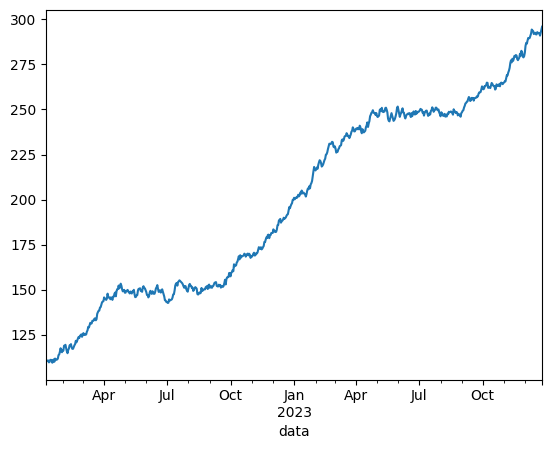

In [37]:
df_tend = df.copy()
df_tend['trend'] = df_tend['vendas'].rolling(window=12, center=True).mean()
plot_not_nan(df_tend, 'trend')

## Análise de sazonalidade

### Multiplicativa

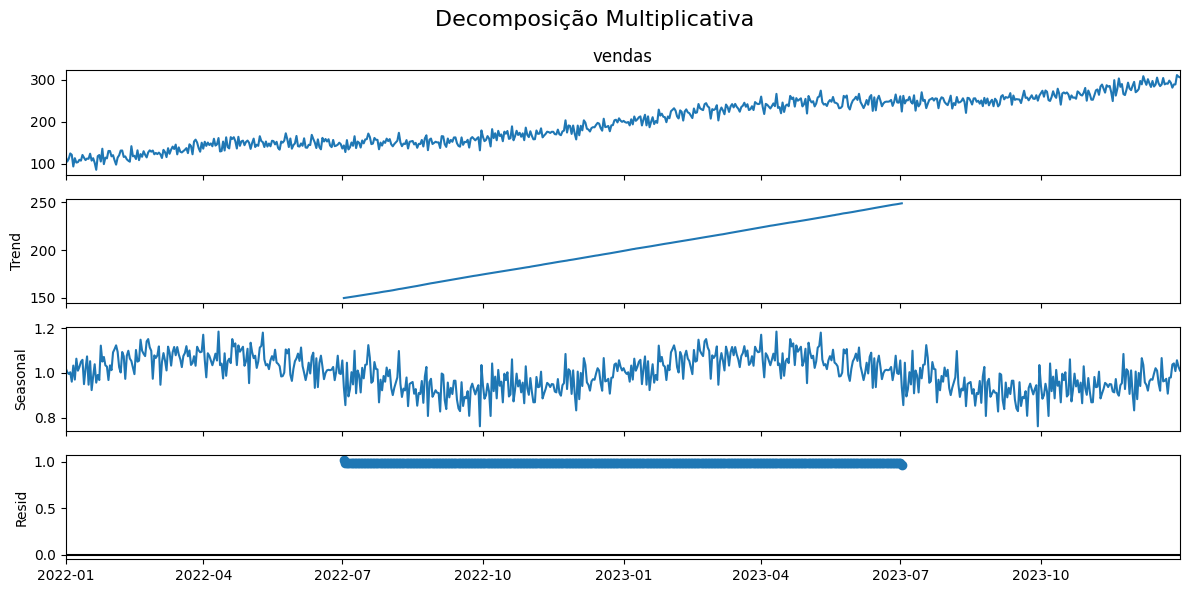

In [38]:
decomp_mult = seasonal_decompose(df['vendas'], model='multiplicative', period=365)

fig_mult = decomp_mult.plot()
fig_mult.set_size_inches(12, 6)
fig_mult.suptitle("Decomposição Multiplicativa", fontsize=16)
plt.tight_layout()
plt.show()

### Aditiva

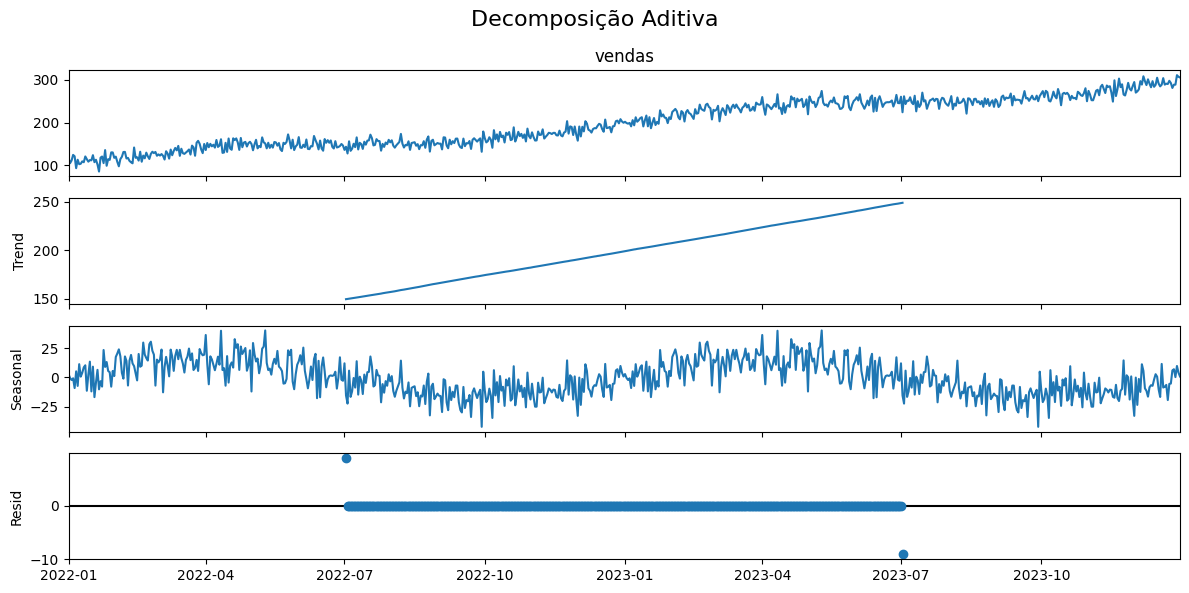

In [39]:
decomp_add = seasonal_decompose(df['vendas'], model='additive', period=365)

fig_add = decomp_add.plot()
fig_add.set_size_inches(12, 6)
fig_add.suptitle("Decomposição Aditiva", fontsize=16)
plt.tight_layout()
plt.show()

## Análise residual

In [42]:
resid_add = decomp_add.resid.dropna()
resid_mult = decomp_mult.resid.dropna()

metrics = pd.DataFrame({
    'Modelo': ['Aditivo', 'Multiplicativo'],
    'Resíduo_STD': [resid_add.std(), resid_mult.std()],
    'RMSE': [np.sqrt((resid_add**2).mean()), np.sqrt((resid_mult**2).mean())]
})

display_all(metrics)

,Modelo,Resíduo_STD,RMSE
0,Aditivo,0.671108,0.672153
1,Multiplicativo,0.002205,0.993369


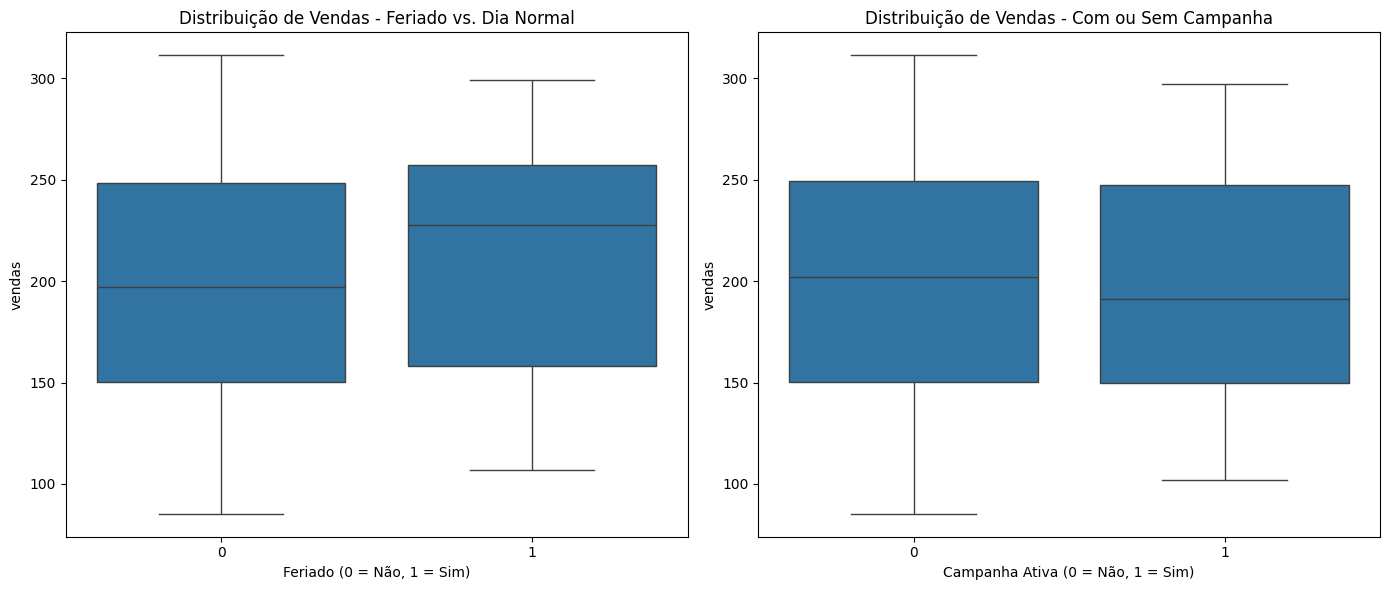

In [27]:
df_plot_impacto = df[['vendas', 'campanha_ativa', 'feriado']].copy()
df_plot_impacto['campanha_ativa'] = df_plot_impacto['campanha_ativa'].astype('category')
df_plot_impacto['feriado'] = df_plot_impacto['feriado'].astype('category')

plt.figure(figsize=(14, 6))

# Vendas por feriado
plt.subplot(1, 2, 1)
sns.boxplot(x='feriado', y='vendas', data=df_plot_impacto)
plt.title('Distribuição de Vendas - Feriado vs. Dia Normal')
plt.xlabel('Feriado (0 = Não, 1 = Sim)')

# Vendas por campanha
plt.subplot(1, 2, 2)
sns.boxplot(x='campanha_ativa', y='vendas', data=df_plot_impacto)
plt.title('Distribuição de Vendas - Com ou Sem Campanha')
plt.xlabel('Campanha Ativa (0 = Não, 1 = Sim)')

plt.tight_layout()
plt.show()